# Agrupamento

<br>

## Análise Inicial do Dataset

O dataset contém 28.847 registros e 9 colunas, e apresenta dados de empregados assalariados em Hyderabad. Aqui estão as colunas e suas características principais:

<br>

  - **candidateName:** Nome do candidato (contém valores nulos).

  - **companyName:** Nome da empresa em que o candidato trabalha (contém valores nulos).

  - **designation:** Cargo do candidato (contém muitos valores nulos).

  - **experienceMas:** Experiência do candidato em anos e meses, registrada como texto.

  - **locationCurrentMas:** Localização atual (majoritariamente "Hyderabad/Secunderabad").

  - **qualificationMas:** Qualificação principal do candidato (contém valores nulos).

  - **qualificationMas2:** Segunda qualificação do candidato (alta quantidade de valores nulos).

  - **salary:** Salário, registrado como texto com a unidade monetária.

  - **Category:** Categoria do candidato (todos os registros são da mesma categoria "HYDERABAD-SALARIED").

<br>

## Modificações e Tratamento Necessário

  - **Remoção de colunas irrelevantes:** Colunas como candidateName, companyName, e Category parecem não agregar muito valor ao processo de agrupamento.

  - **Tratamento da coluna salary:** Essa coluna está no formato de string e precisa ser convertida em valores numéricos para uso no modelo de agrupamento.

  - **Conversão de experienceMas:** Essa coluna contém a experiência em formato textual ("2 Year(s) 1 Month(s)") e deve ser convertida em um valor numérico (total de meses ou anos).

  - **Tratamento de valores nulos:** Colunas como designation, qualificationMas, e qualificationMas2 contêm valores nulos que precisarão ser tratados, seja por remoção ou preenchimento com valores padrões.

  - **Normalização dos dados:** O valor de salário e experiência, após serem convertidos, deverão ser normalizados para o modelo de K-Means.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

## Carregamento e Visualização dos Dados

  - O dataset contém informações de empregados assalariados. Colunas como **salary** e **experienceMas** são particularmente importantes para a análise de agrupamento.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/hyderabad-salaried-employees.csv')

df.head()

,candidateName,companyName,designation,experienceMas,locationCurrentMas,qualificationMas,qualificationMas2,salary,Category
0,Ruchismita Dash,Amdocs,Software Developer,2 Year(s) 1 Month(s),Hyderabad/ Secunderabad,BE/ B.Tech (Engineering),NaN,Rs. 6.71 lacs,HYDERABAD-SALARIED
1,MANISHA DAS,APOLLO HOSPITALS ENTERPRISES LIMITED,SENIOR EXECUTIVE-OPERATIONS,5 Year(s) 9 Month(s),Hyderabad/ Secunderabad,MBA/ PGDM,B.Pharm. (Pharmacy),Rs. 5.0 lacs,HYDERABAD-SALARIED
2,C J GEETHA PRIYA,propertyoneshop.com,System Administrator,4 Year(s) 4 Month(s),Hyderabad/ Secunderabad,B.Com. (Commerce),NaN,Rs. 84.0 lacs,HYDERABAD-SALARIED
3,SRIKANTH,Axis Bank Ltd,NaN,7 Year(s) 11 Month(s),Hyderabad/ Secunderabad,NaN,MBA/ PGDM,Rs. 7.0 lacs,HYDERABAD-SALARIED
4,Madduri Srinivas,CTS,Associate Projects,6 Year(s) 8 Month(s),Hyderabad/ Secunderabad,B.Com. (Commerce),MCA/ PGDCA,Rs. 8.05 lacs,HYDERABAD-SALARIED


## Tratamento e Pré-processamento dos Dados

  - As colunas **candidateName**, **companyName**, e **Category** serão removidas por não agregarem ao processo de agrupamento. A coluna **salary** será convertida para um valor numérico, e **experienceMas** será transformada em uma métrica em meses.

In [ ]:
## Remover colunas irrelevantes
df.drop(columns=['candidateName', 'companyName', 'Category'], inplace=True)

# Converter a coluna 'salary' para numérico
df['salary'] = df['salary'].str.replace('Rs. ', '').str.replace(' lacs', '').astype(float)

# Converter a coluna 'experienceMas' para meses
def convert_experience_to_months(exp):
    if pd.isna(exp):
        return np.nan
    years, months = 0, 0
    if 'Year' in exp:
        years = int(exp.split('Year(s)')[0].strip())
    if 'Month' in exp:
        months = int(exp.split('Month(s)')[0].split()[-1].strip())
    return years * 12 + months

df['experience_months'] = df['experienceMas'].apply(convert_experience_to_months)
df.drop(columns=['experienceMas'], inplace=True)

## Tratamento de *outliers*


- Dados fora de padrão podem influenciar o agrupamento. Buscando um melhor score, os outliers (empregados com salários e experiência muito fora da curva) serão removidos.

In [ ]:
df.query('salary > 14000 ')

,designation,locationCurrentMas,qualificationMas,qualificationMas2,salary,experience_months
18656,NaN,Hyderabad/ Secunderabad,NaN,NaN,14210.65,17


In [ ]:
df.query('experience_months > 1000')

,designation,locationCurrentMas,qualificationMas,qualificationMas2,salary,experience_months
7778,Business Devlopment Manager,Hyderabad/ Secunderabad,B.Sc. (Science),NaN,9.85,1028
18817,Business Development Manager ;SrInside Sales A...,Hyderabad/ Secunderabad,MBA/ PGDM,BCA (Computer Application),6.90,1080
26487,Purchasing Manager,Hyderabad/ Secunderabad,B.Com. (Commerce),NaN,6.90,1090


In [ ]:
df = df.query('salary < 14000')
df = df.query('experience_months < 1000')

## Tratamento de Valores Nulos

  - As colunas com valores nulos (como **designation**, **qualificationMas**, **qualificationMas2**) serão preenchidas ou removidas conforme necessário.

In [ ]:
# Preencher valores nulos em 'designation' com 'Unknown'
df.fillna({'designation': 'Unknown'}, inplace=True)

# Preencher valores nulos em 'qualificationMas' e 'qualificationMas2' com 'None'
df.fillna({'qualificationMas': 'None'}, inplace=True)
df.fillna({'qualificationMas2': 'None'}, inplace=True)

# Verificar se há mais valores nulos
df.isnull().sum()

,0
designation,0
locationCurrentMas,0
qualificationMas,0
qualificationMas2,0
salary,0
experience_months,0


## Normalização dos Dados

  - Para o modelo `K-Means`, é necessário normalizar as variáveis contínuas (como salário e experiência). Para isso, será utilizado o `MinMax Scaler`.

In [ ]:
# Normalizar as variáveis contínuas
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['salary', 'experience_months']])
print(f'\n{df_scaled}')


[[1.79057592e-03 2.54841998e-02]
 [0.00000000e+00 7.03363914e-02]
 [8.27225131e-02 5.30071356e-02]
 ...
 [2.30366492e-04 2.34454638e-02]
 [5.23560209e-05 6.93170234e-02]
 [2.61780105e-03 4.07747197e-03]]


## Escolha da Quantidade de Clusters

  - O número de clusters será determinado pelo **método do cotovelo**.

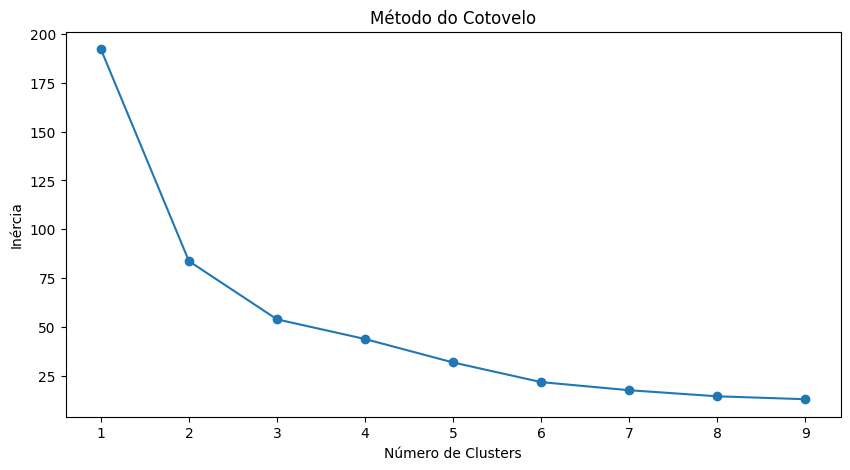

In [ ]:
# Testar diferentes quantidades de clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10,5))
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.show()

## Treinamento do Modelo K-Means

- Após observação do gráfico do método do cotovelo, o número de clusters deve ser **2** ou **3**.

In [ ]:
# Definindo o número de clusters
k = 2

# Treinando o modelo K-Means
kmeans = KMeans(n_clusters=k)
df['Cluster'] = kmeans.fit_predict(df_scaled)

## Avaliação e Visualização



Silhouette Score: 0.618985456103428 (61.90%)



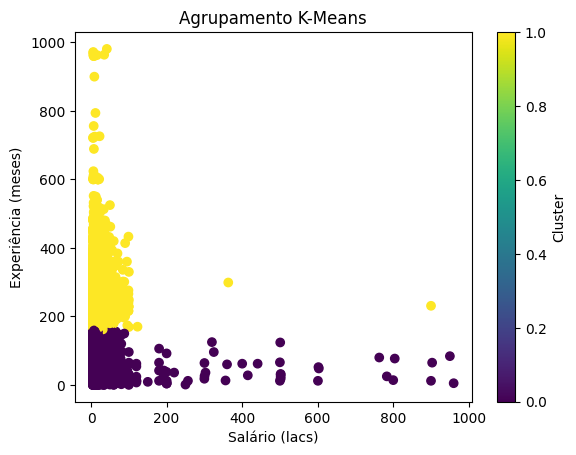

In [ ]:
# Avaliando o modelo com o Silhouette Score
score = silhouette_score(df_scaled, df['Cluster'])
print(f'Silhouette Score: {score} ({score * 100:.2f}%)\n')

# Visualizando os clusters
plt.scatter(df['salary'], df['experience_months'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Salário (lacs)')
plt.ylabel('Experiência (meses)')
plt.title('Agrupamento K-Means')
plt.colorbar(label='Cluster')
plt.show()